# FORS1 longslit observations of NGC 343

These are spectra that are described in [Valerdi et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...876...98V). 

What I want to do here is analyze the spectra at their full angular resolution, rather than binned in 10-arcsecond windows, as was done in that paper.  This is necessary for investigating the spectrum of W 3's bow shock.

Slit A crosses W 3 (near enough) and is close to the axis of the bow shock.  It shows the compact He II 4686 emission from the inner rim. 

Slit B is parallel to A, displaced 8 arcsec to south.  It just misses the inner rim, but does show the enhanced [Ar IV] zone of the bow shock. 

I would like to achieve the following:

1. [X] Identify W 3 and the bow shock in the spectra
2. [ ] Trace the full western extent of the bow shock in [Ar IV]
    - the MUSE field extends only 22 arcsec from the star 
    - the FORS1 spectrum shows a roughly linear ramp that extends about 34 arcsec (see image below)
3. [ ] Calculate the [O III] 4363/5007 temperature profile of the bow shock
    - See if there is any evidence for temperatures as high as the [Ar IV] temperature
4. [ ] Measure the [Ne III] 3869 profile.  Ne$^+$ has the same ionization potential as Ar$^{+2}$ (40 eV), but [Ne III] seems to be much more broadly distributed than [Ar IV] 



![FORS1 profile of Ar IV](assets/ngc346-screenshot-fors1-ariv-profile.png)


In [8]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import regions
from astropy.io import fits
from astropy.wcs import WCS


sns.set_context("talk")
sns.set_color_codes()

MPDAF does not seem to have good functionality for dealing with position–velocity images, so we will just use basic astropy functionality.

In [9]:
hdulist = fits.open("../data/30050000.346A.04.1.B.W.fits")
hdulist.info()

Filename: ../data/30050000.346A.04.1.B.W.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     251   (2048, 2048)   float32   


In [12]:
slitA = hdulist[0]
w = WCS(slitA.header, fix=False)
w

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/astropy/wcs/wcs.py:2855: RuntimeWarning: cdelt will be ignored since cd is present
  description.append(s.format(*self.wcs.cdelt))


WCS Keywords

Number of WCS axes: 2
CTYPE : 'LINEAR'  'LINEAR'  
CRVAL : 3561.03466796875  1.0  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 0.0  -1.0  
PC2_1 PC2_2  : 1.0  0.0  
CDELT : 1.17881751060486  1.0  
NAXIS : 2048  2048

That PC matrix is not right, so I switch it back to the identity matrix:

In [ ]:
w.wcs.pc = np.eye(2)

While we are here, we can give names and units to the axes.  And change the spatial axis from pixels to arcsec.  Also, put the spatial origin at the position of the star W3.

In [69]:
w.wcs.cname = "wavelength", "position"
w.wcs.cunit = "Angstrom", "arcsec"
w.wcs.cd[1, 1] = 0.2
w.wcs.crpix[1] = 900.0
w.wcs.crval[1] = 0.0

Plot the full spectrum at different brightness levels:

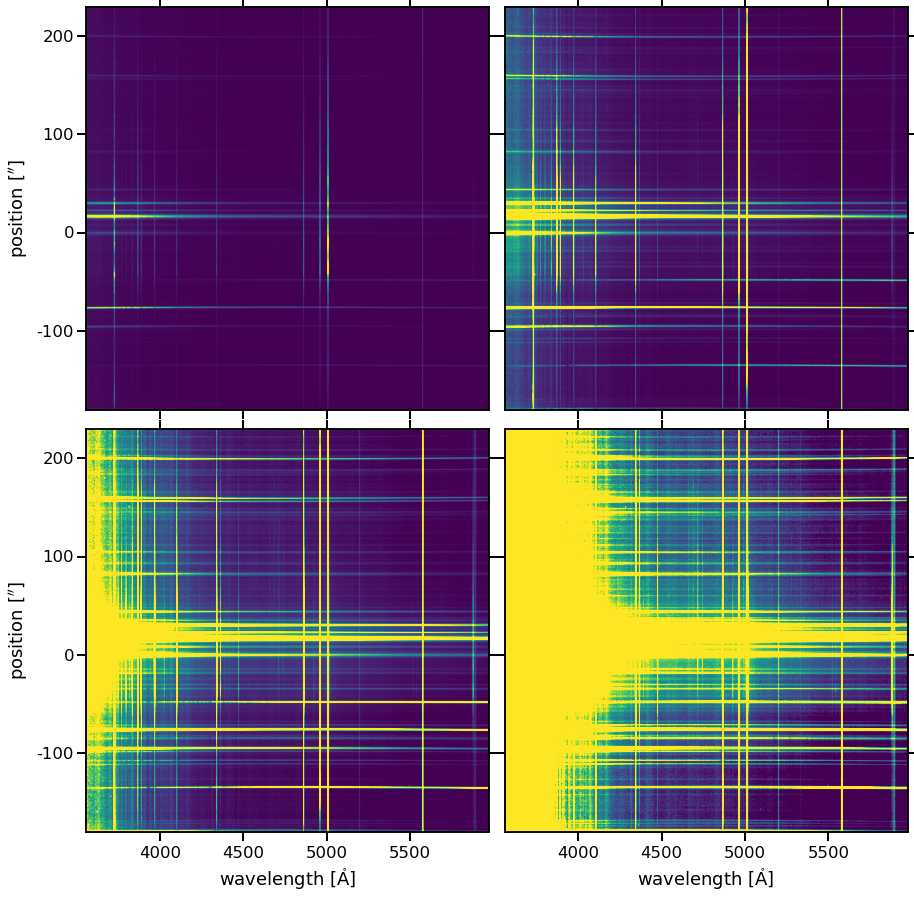

In [70]:
fig, axes = plt.subplots(
    2, 2,
    figsize=(12, 12),
    subplot_kw=dict(projection=w),
    sharex=True,
    sharey=True,
)
for ax, vmax in zip(axes.flat, [3000, 300, 100, 30]):
    ax.imshow(slitA.data, origin="lower", vmin=10, vmax=vmax)
for ax in axes[:, 1]:
    ax.coords[1].set_ticklabel_visible(False)
    ax.coords[1].set_axislabel(" ")
for ax in axes[0, :]:
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[0].set_axislabel(" ")
fig.tight_layout();

Make a function that extracts a rectangular sub-image, specified in world coordinates.  It also returns the corresponding WCS for use in plotting:

In [71]:
def pvslice(im, w, wavrange, posrange):
    """
    Return the (image, wcs) tuple of a sub-image of the PV image `im`
    with WCS `w` for the wavelength range `wavrange` and the position range `posrange`
    
    """
    xlim, ylim = w.world_to_pixel_values(wavrange, posrange)
    xslice, yslice = slice(*xlim.astype(int)), slice(*ylim.astype(int))
    return im[yslice, xslice], w.slice((yslice, xslice))

Test it out by plotting the He II and [Ar IV] lines from bow shock

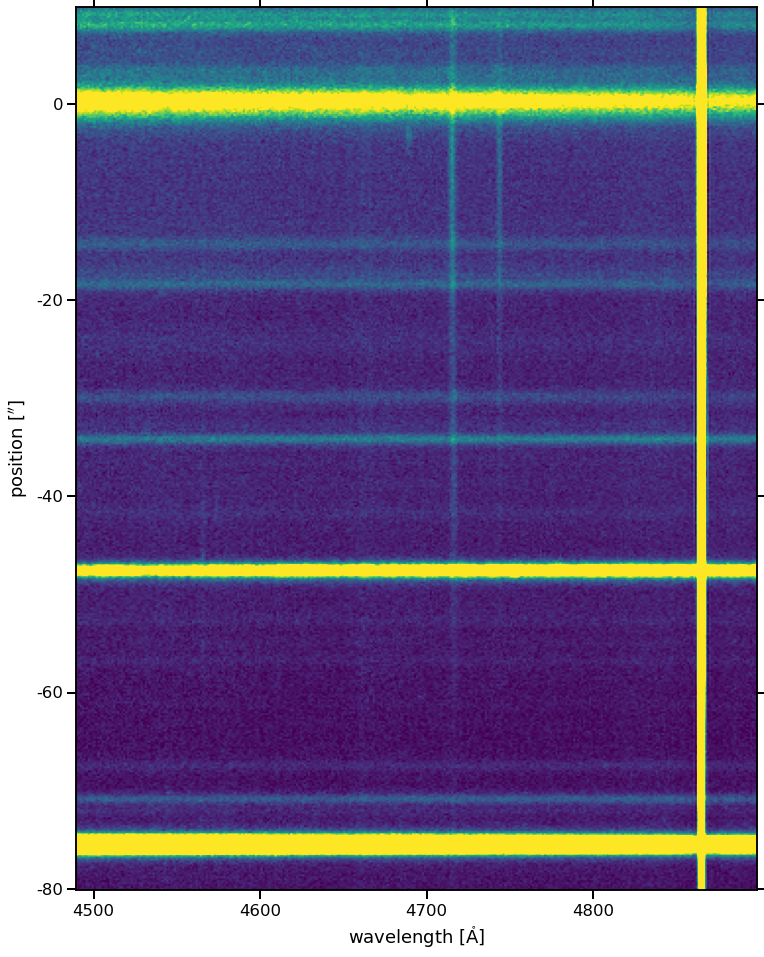

In [72]:
im, ww = pvslice(slitA.data, w, [4490, 4900], [-80, 10])
fig, ax = plt.subplots(
    figsize=(10, 15),
    subplot_kw=dict(projection=ww),
)
ax.imshow(im, origin="lower", vmin=10, vmax=100)
fig.tight_layout();

We can also use it for plotting a 1D spectrum

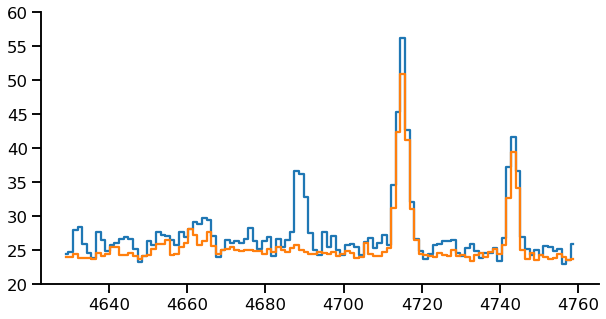

In [83]:
fig, ax = plt.subplots(
    figsize=(10, 5),
)

wav1, wav2 = 4630, 4760
im, ww = pvslice(slitA.data, w, [wav1, wav2], [-5, -3])
spec = im.mean(axis=0)
n = len(spec)
wavs, _ = ww.pixel_to_world_values(np.arange(n), [0]*n)
ax.plot(wavs, spec, drawstyle="steps-mid")

im, ww = pvslice(slitA.data, w, [wav1, wav2], [-15, -5])
spec2 = im.mean(axis=0)
ax.plot(wavs, spec2, drawstyle="steps-mid")

ax.set(
    ylim=[20, 60],
)
sns.despine();

And for plotting profile cuts

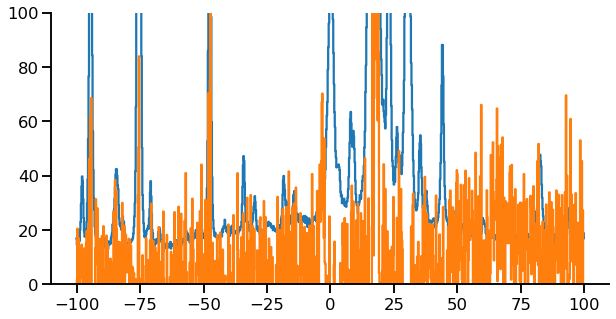

In [93]:
fig, ax = plt.subplots(
    figsize=(10, 5),
)
smin, smax = -100, 100

# Continua
im, ww = pvslice(slitA.data, w, [4670, 4680], [smin, smax])
cont01 = im.mean(axis=1, keepdims=True)
n, _ = cont01.shape
_, positions = ww.pixel_to_world_values([0]*n, np.arange(n))

im, ww = pvslice(slitA.data, w, [4695, 4710], [smin, smax])
cont02 = im.mean(axis=1, keepdims=True)

im, ww = pvslice(slitA.data, w, [4728, 4739], [smin, smax])
cont03 = im.mean(axis=1, keepdims=True)

im, ww = pvslice(slitA.data, w, [4750, 4760], [smin, smax])
cont04 = im.mean(axis=1, keepdims=True)

# Lines
im, ww = pvslice(slitA.data, w, [4682, 4698], [smin, smax])
i4686 = (im - 0.5*(cont01 + cont02)).sum(axis=1)

c4686 = (0.5*(cont01 + cont02)).sum(axis=1)





ax.plot(positions, c4686, drawstyle="steps-mid")
ax.plot(positions, i4686, drawstyle="steps-mid")

ax.set(
    #yscale="log",
    ylim=[0, 100],
)
sns.despine();

In [88]:
positions

array([-100.])

In [51]:
w.slice( (slice(*ylim.astype(int)), slice(*xlim.astype(int))))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/astropy/wcs/wcs.py:2855: RuntimeWarning: cdelt will be ignored since cd is present
  description.append(s.format(*self.wcs.cdelt))


WCS Keywords

Number of WCS axes: 2
CTYPE : 'LINEAR'  'LINEAR'  
CRVAL : 3561.03466796875  1.0  
CRPIX : -787.0  -494.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.17881751060486  0.2  
NAXIS : 263  500

In [60]:
w.axis_type_names

['wavelength', 'position']

In [89]:
n

1